# Predicting Loan Status Based on Applicant Income and Loan Amount

## Introduction

### Background Information

Applying for a loan can be a tiring, extensive process: many variables can affect one's loan approval status, and it is hard to determine which one is more significant for a successful application. Knowing what to look for in a loan application to ensure success is definitely essential, given that getting rejected for a loan can affect credit score. Thus, making it harder to get loans in the future. In trying to solve or at least facilitate this common problem most people encounter in their lives, this project aims to answer the following question: **"Is it possible to determine loan approval status based on household income (co-applicant and applicant income), loan term, and loan amount?."**

### Dataset Description

To answer the proposed question, the dataset `loan_data.csv` will be used. `loan_data.csv`, which contains information on several loan applicants, was downloaded from Kaggle(same as source) and will be loaded into R (demonstrated further). The dataset contains 13 columns and 381 rows, each of which represent a unique observation (i.e a loan application). Each column in the dataset represents the following:

- **`Loan_ID`:** A unique loan ID.
- **`Gender`:** applicant gender, being male or female.
- **`Married`:** applican marital status, being married(yes) or not married(No).
- **`Dependents`:** Number of persons depending on the applicant.
- **`Education`:** Applicant Education, being graduate or undergraduate.
- **`Self_Employed`:** If applicant is self-employed, options being yes or no.
- **`ApplicantIncome`:** Applicant income in dollars ($).
- **`CoapplicantIncome`:** Co-applicant income in dollars ($).
- **`LoanAmount`:** Loan amount in thousands of dollars ($).
- **`Loan_Amount_Term`:** Terms of the loan in months.
- **`Credit_History`:** if applicant's credit history meets guidelines.
- **`Property_Area`:** If applicants are living in urban, semi-Urban or rural setting.
- **`Loan_Status`:** Loan approved, options being yes or no.

## Methods and results

**Source:** https://www.kaggle.com/datasets/bhavikjikadara/loan-status-prediction

In [15]:
## Required packages and versions
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("themis")
library(themis)
options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows
set.seed(2024)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



### Preliminary Exploratory Data Analysis

#### 1. Load the Original Dataset

In [16]:
loan_data <- read_csv("https://raw.githubusercontent.com/maricardosoo/DSCI-100-group-project/main/data/loan_data.csv")

Rows: 381 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): Loan_ID, Gender, Married, Dependents, Education, Self_Employed, Pro...
dbl (5): ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, C...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


##### **Table 1: Untidy `loan_data`**

With Table 1, it is possible to examine the original dataset, loan_data. Due to the large number of observations, it is necessary to use head(loan_data) to get an overview of the dataset. The first 6 rows of the original dataset `loan_data` are shown below.

In [17]:
head(loan_data)
nrow(loan_data)

Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
LP001003,Male,Yes,1,Graduate,No,4583,1508,128,360,1,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0,66,360,1,Urban,Y
LP001006,Male,Yes,0,Not Graduate,No,2583,2358,120,360,1,Urban,Y
LP001008,Male,No,0,Graduate,No,6000,0,141,360,1,Urban,Y
LP001013,Male,Yes,0,Not Graduate,No,2333,1516,95,360,1,Urban,Y
LP001024,Male,Yes,2,Graduate,No,3200,700,70,360,1,Urban,Y


[1] 381

From the original dataset table above, a few problems can be noticed, which will be addressed in the data cleaning process:

1. The column `Loan_Status` is not stored as a categorical variable.
2. There is no variable for the total income amount of the applicant's household.
3. There are rows with missing values.
4. Some of the column names are not standardized. Some spaces are separated with underscores, such as `Self_Employed`, some with capital letters, such as `LoanAmount`.

#### 2. Data wrangling and cleaning

The following steps were done to prepare the data:

1. Used the `mutate` and `as_factor` functions to change column `Loan_Status` to a categorical variable.
2. Use the `mutate` function to create a new column named `TotalIncome` using the `ApplicantIncome` and `CoapplicantIncome` columns. Thus, creating a new colum for the total household income (i.e applicant and co-applicant income).
3. Use the `drop_na()` function to drop rows containing missing values.
4. Standardize the column names by assigning the new column names to a vector and passing it to the `colnames` function.

In [18]:
# clean the dataset accordingly
loan_data <- read_csv("https://raw.githubusercontent.com/maricardosoo/DSCI-100-group-project/main/data/loan_data.csv")

loan_data <- loan_data |> 
    mutate(Loan_Status = as_factor(Loan_Status)) |>
    mutate(TotalIncome = ApplicantIncome + CoapplicantIncome) |>
    drop_na() |>
    select(-Loan_ID, -Gender, -Married, -Property_Area)

# Standardising column names
colnames(loan_data) <- c("Dependents", "Education", "SelfEmployed", "ApplicantIncome", "CoapplicantIncome", "LoanAmount", "LoanTerm", "CreditHistory", "LoanStatus", "TotalIncome")

Rows: 381 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): Loan_ID, Gender, Married, Dependents, Education, Self_Employed, Pro...
dbl (5): ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, C...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


As seen in the table above, there is significantly (~48%) more positive classes (LoanStatus == Y) than negative classes. This class imbalance could lead to worse performance in our classifier. Hence, there is a need to balance these classes by 

##### **Table 2: Tidy `loan_data`**

Below, it is possible to examine the cleaned version of `loan_data`. Due to the large number of observations, the function head(`loan_data`) was to get an idea of what the dataset looks like. The first 6 rows of the cleaned dataset are shown below.

In [19]:
head(loan_data)

Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanTerm,CreditHistory,LoanStatus,TotalIncome
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,Graduate,No,4583,1508,128,360,1,N,6091
0,Graduate,Yes,3000,0,66,360,1,Y,3000
0,Not Graduate,No,2583,2358,120,360,1,Y,4941
0,Graduate,No,6000,0,141,360,1,Y,6000
0,Not Graduate,No,2333,1516,95,360,1,Y,3849
2,Graduate,No,3200,700,70,360,1,Y,3900


### 3. Initial Split and Training Data Summary Tables for `loan_data`

1. First, it is necessary to create an initial split of the data, `loan_split`, dividing it into training data, `loan_train`, and testing data, `loan_test`. Since the goal is to predict loan status, the strata is to this target variable, `LoanStatus`. The proportion of the dataset allocated to training data is 0.75.

In [20]:
loan_split <- initial_split(loan_data, prop = 0.75, strata = LoanStatus)
loan_train <- training(loan_split)
loan_test <- testing(loan_split)

##### **Table 3: Training Dataset**

Below, it is possible to examine the training data `loan_train`. The first 6 rows of the training dataset are shown below, using the function `head(loan_train)`.

In [21]:
head(loan_train)

Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanTerm,CreditHistory,LoanStatus,TotalIncome
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,Graduate,No,4583,1508,128,360,1,N,6091
0,Graduate,No,3510,0,76,360,0,N,3510
0,Not Graduate,No,4887,0,133,360,1,N,4887
0,Not Graduate,No,7660,0,104,360,0,N,7660
0,Not Graduate,No,2600,1911,116,360,0,N,4511
0,Not Graduate,No,1442,0,35,360,1,N,1442


2. *TODO* provide a description of summary data

In [22]:
loan_train_summary <- loan_train |>
    group_by(LoanStatus) |>
    summarize(Count = n(), MeanApplicantIncome = mean(ApplicantIncome), MeanCoapplicantIncome = mean(CoapplicantIncome), MeanLoanAmount = mean(LoanAmount), MeanLoanTerm = mean(LoanTerm))

##### **Table 4: Training Dataset Summary**

In [23]:
loan_train_summary

LoanStatus,Count,MeanApplicantIncome,MeanCoapplicantIncome,MeanLoanAmount,MeanLoanTerm
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
N,66,3417.439,1437.970,100.1667,345.0909
Y,164,3638.348,1215.457,104.1646,340.7561


*TODO* provide implications of training dataset summary

### 4. Preliminary visualization of data

#### 4.1. Distribution of key predictors

**Predictor Distributions:** It is necessary to visualize the distribution of the predictors (`ApplicantIncome`, `CoapplicantIncome`, `LoanAmount`, and `LoanTerm`) to gather more information on the data set and better understand the implications of their usage in the knn algorithm. To do so, it is necessary to create 5 histograms: `income_dist_plot`, `coincome_dist_plot`, `loan_amount_plot`, `loan_term_plot`, and `loan_combined_plot`.

*TODO* add figure labels for each plot

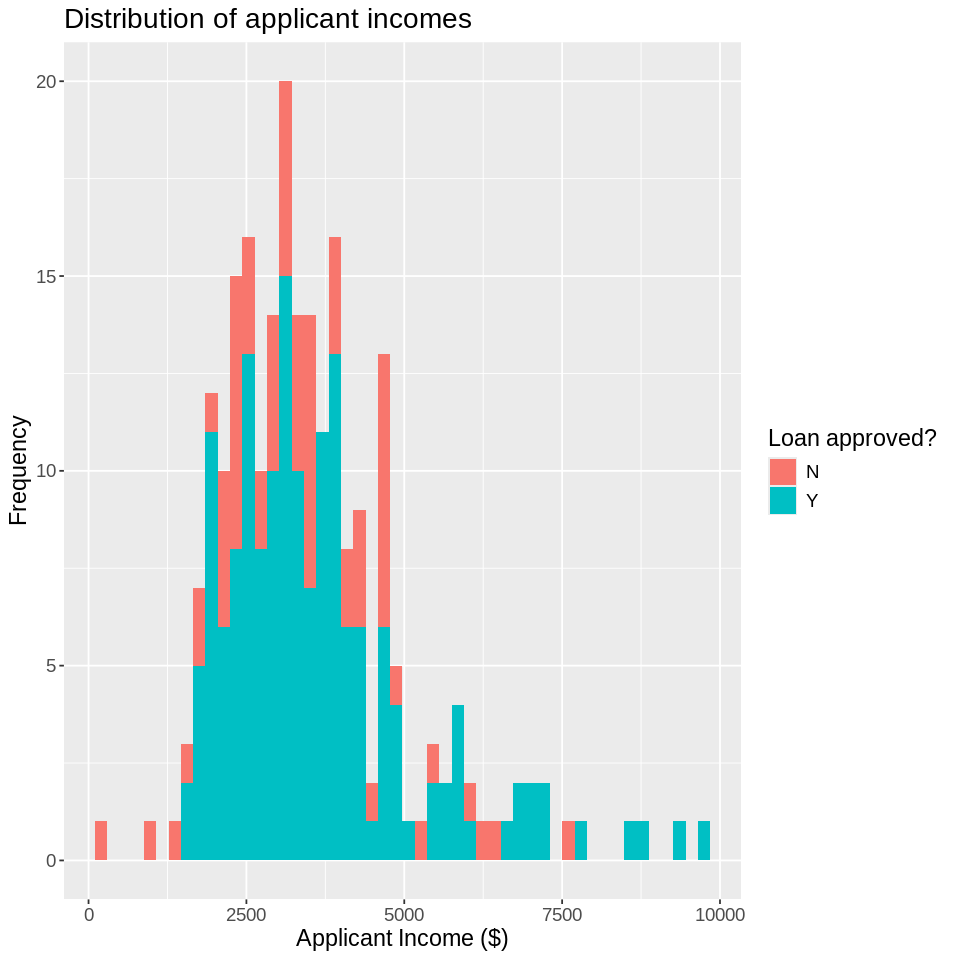

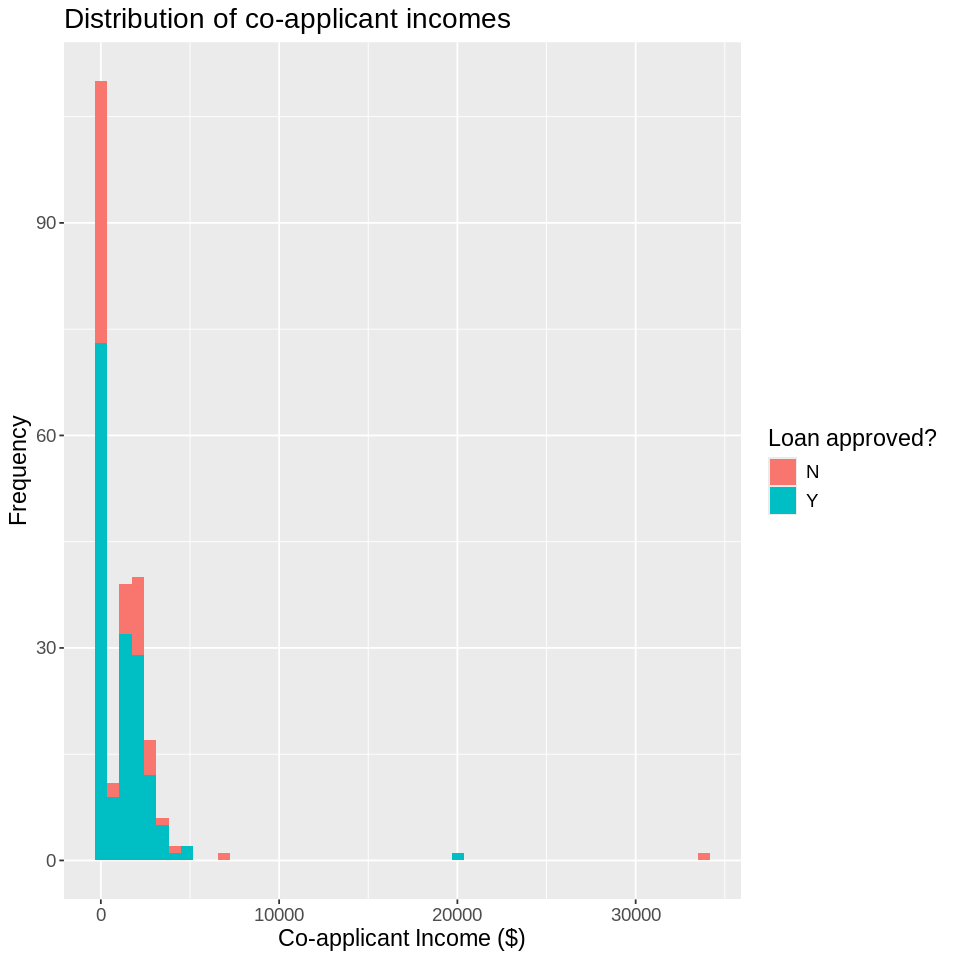

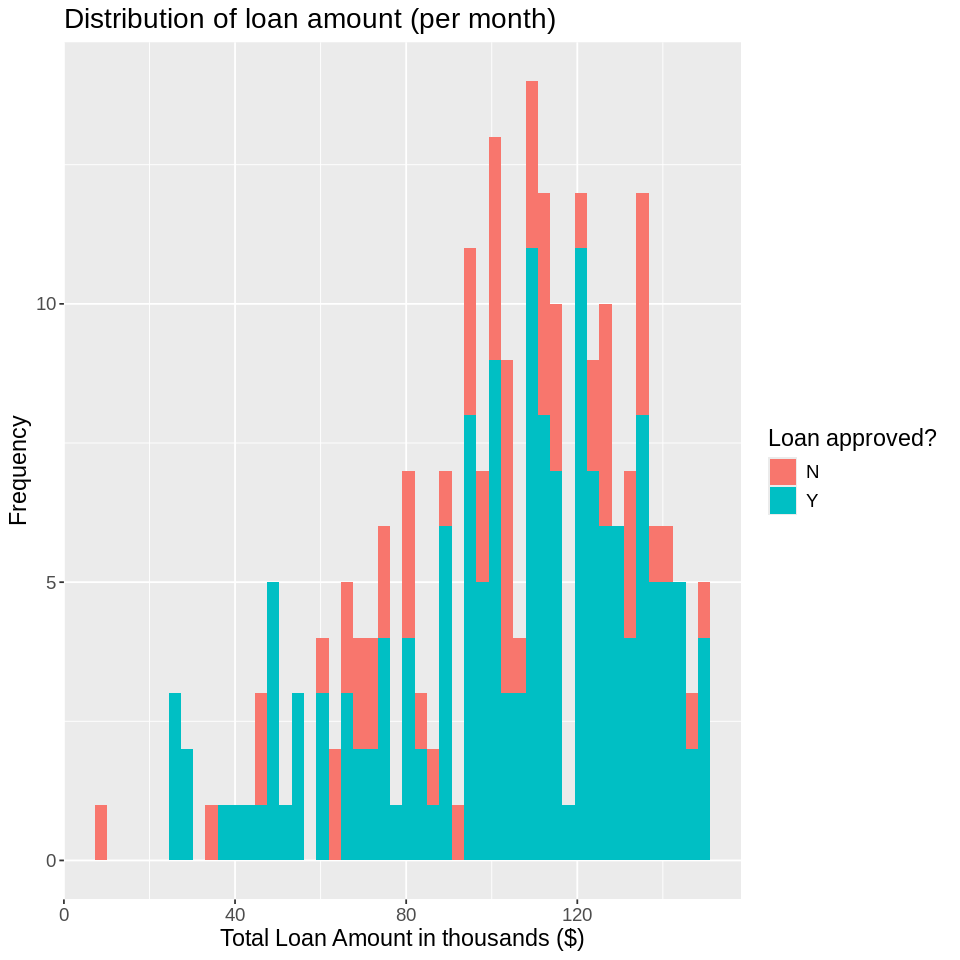

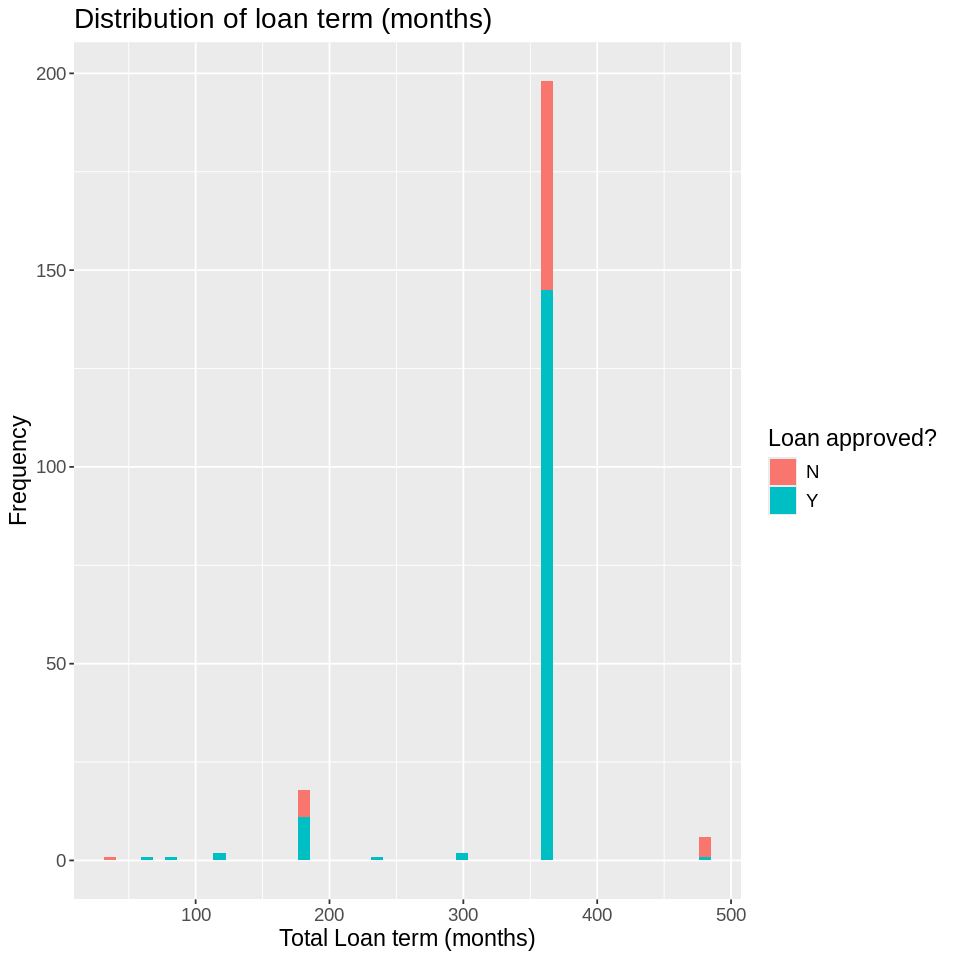

In [24]:
options(repr.plot.width=8, repr.plot.height=8)

income_dist_plot <- loan_train |>
    ggplot(aes(x=ApplicantIncome, fill=LoanStatus)) +
    geom_histogram(bins=50) +
    labs(title = "Distribution of applicant incomes", x = "Applicant Income ($)", y = "Frequency", fill="Loan approved?") +
    theme(text = element_text(size = 14))
income_dist_plot

coincome_dist_plot <- loan_train |>
    ggplot(aes(x=CoapplicantIncome, fill=LoanStatus)) +
    geom_histogram(bins=50) +
    labs(title = "Distribution of co-applicant incomes", x = "Co-applicant Income ($)", y = "Frequency", fill="Loan approved?") +
    theme(text = element_text(size = 14))
coincome_dist_plot

loan_amount_plot <- loan_train |>
    ggplot(aes(x=LoanAmount, fill=LoanStatus)) +
    geom_histogram(bins=50) +
    labs(title = "Distribution of loan amount (per month)", x = "Total Loan Amount in thousands ($)", y = "Frequency", fill="Loan approved?") +
    theme(text = element_text(size = 14))
loan_amount_plot

loan_term_plot <- loan_train |>
    ggplot(aes(x=LoanTerm, fill=LoanStatus)) +
    geom_histogram(bins=50) +
    labs(title = "Distribution of loan term (months)", x = "Total Loan term (months)", y = "Frequency", fill="Loan approved?") +
    theme(text = element_text(size = 14))
loan_term_plot

#### 4.2. Relationship between Income and Loan Amount

**Relationship Analysis:** To prepare for the KNN classification, it is necessary to explore the relationship between predictor variables and the response variable. The scatter plot `relationship_plot` should better demonstrate the relationship between `TotalIncome`, `TotalLoanAmount` and `LoanStatus`.

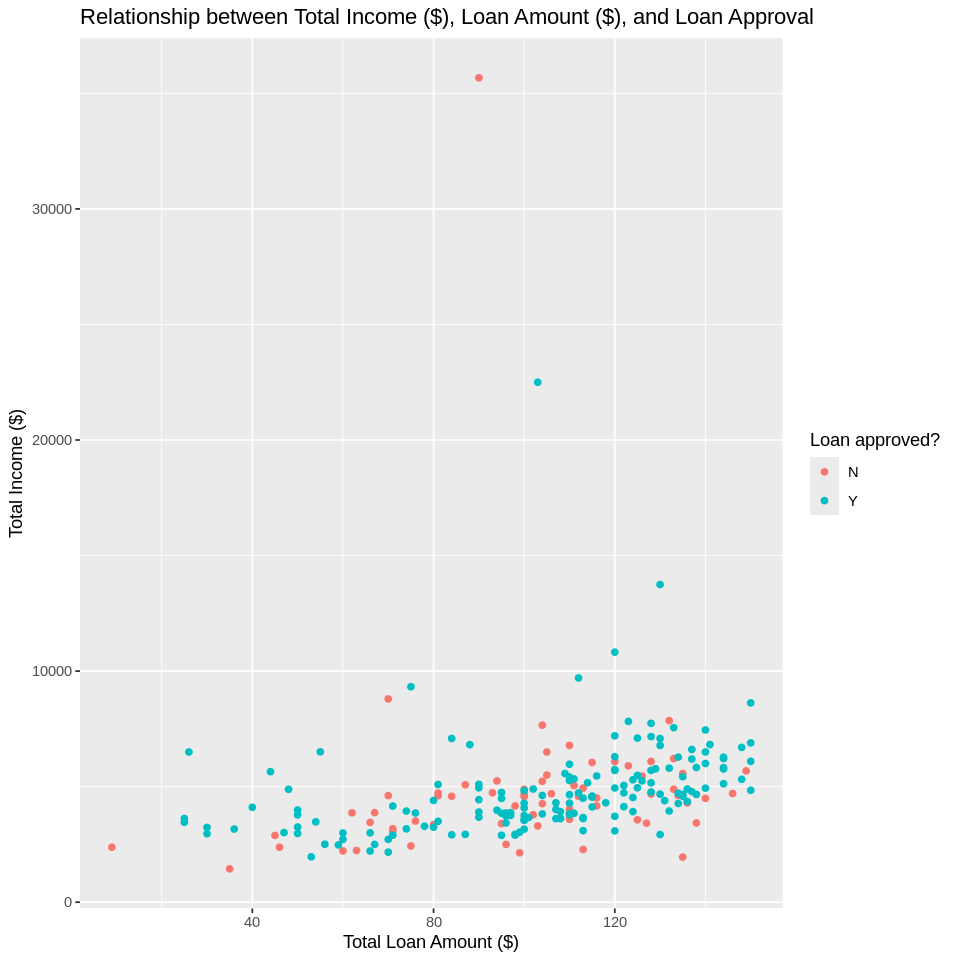

In [25]:
relationship_plot <- loan_train |>
    ggplot(aes(x=LoanAmount, y=TotalIncome, color=LoanStatus)) +
    geom_point() + 
    labs(title = "Relationship between Total Income ($), Loan Amount ($), and Loan Approval", x="Total Loan Amount ($)", y="Total Income ($)", color="Loan approved?")
relationship_plot

#### 5. Predictors Selection and Data Analysis from Visualization

 This project aims to use the following variables as predictors:
 - `ApplicantIncome`: Monthly income in dollars for the main applicant
 - `CoapplicantIncome`: Monthly income in dollars for any co-applicants in the main applicant's household
 - `LoanAmount`: Loan amount in thousands of dollars
 - `LoanTerm`: Loan term in months

 *TODO* explain why we chose these predictors

In the preliminary data analysis, the data summary includes the number of occurrences for each class, and the mean values of the predictors intended to be used.

**1.** There are almost twice as many positive `LoanStatus` class occurrences as negative ones. This will lead to a class imbalance that affects the classifier's performance. To solve this, either an upsample of the negative classes or a downsample of the positive classes will be necessary.

**2.** The predictors intended to be used have largely the same mean values for both the positive and negative classes. This could be due to large variance or outliers within the predictors affecting the mean.

The visualizations created involve the distributions of the predictors intended to be used. From the visualizations, it is possible to see that there are some class imbalances for outlier values, especially in `Applicant/co-applicantIncome` and the `LoanTerm`. This could lead to poor classification for new observations near the outlier values and may need to be removed.

Other visualizations involving scatter plots of the relationships between predictors will be necessary. This will allow for determining if there is any clear grouping occurring, and to potentially determine which predictors are the most important in the classifier.

## Creating the model

To create our model, the following steps will be taken:

1. Create a recipe that predicts ```LoanStatus```, with ```ApplicantIncome, CoapplicantIncome, LoanAmount, LoanTerm``` as predictors.
2. Create a specification that uses k-nearest neighbors, with neighbors = tune() to select the best ```K``` value.
3. Split the data into 10 folds to perform cross-validation.
4. Create a workflow to train the classifier with ```tune_grid()```.

### 1. Dealing with class imbalance

As seen in the summary table presented previously, the positive class (LoanStatus == Y) appears significantly (~48%) more than the negative class. This imbalance could lead to poor performance of the classifier. When building the model,the negative class will be upsampled by using ```step_upsample()``` as part of the recipe. It is important to set ```skip = TRUE``` to ensure that the upsampling is done only on the training data.

The predictors were also centered and scaled to ensure they have equal impact on the classifier.

In [26]:
loan_recipe <- recipe(LoanStatus ~ ApplicantIncome + CoapplicantIncome + LoanAmount +  LoanTerm + CreditHistory, data = loan_train) |>
    step_upsample(LoanStatus, skip = TRUE) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

### 2. Training the model

In [27]:
# K-nearest neighbour model specification
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

# Perform 10 fold-cross valdiation
loan_vfold <- vfold_cv(loan_train, v = 10, strata = LoanStatus)

# K value in range [0, 50]
gridvals <- tibble(neighbors = c(1:50))

# Create workflow
knn_results <- workflow() |>
      add_recipe(loan_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = loan_vfold, grid = gridvals) |>
# Collect metrics, filter for accuracy
      collect_metrics() |>
      filter(.metric == "accuracy") |>
      select(neighbors, mean) |>
      arrange(desc(mean))

head(knn_results)

neighbors,mean
<int>,<dbl>
49,0.8440053
50,0.8440053
3,0.8356719
4,0.8356719
47,0.8352931
48,0.8352931


### 3. Choosing a ```K``` value

- *TODO* do some more description of our chosen K value and choice of visualization to do so.
- *TODO* provide labels for visualization

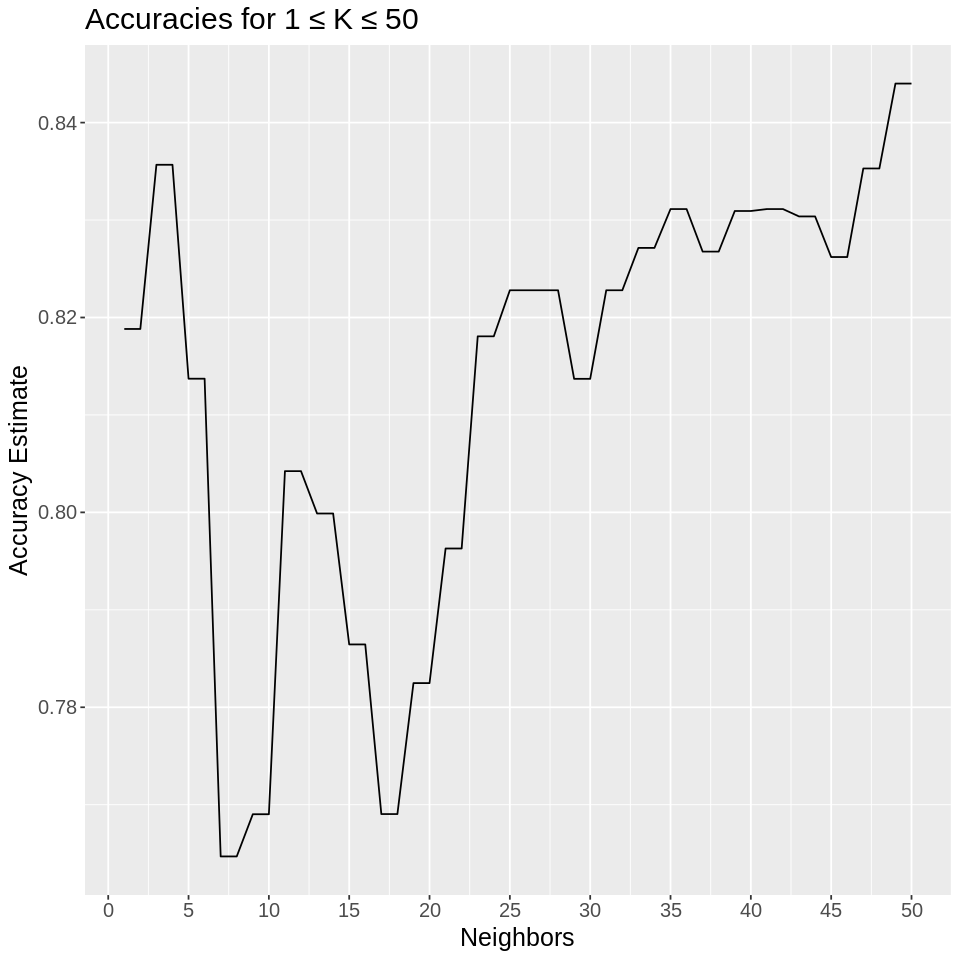

In [28]:
accuracy_versus_k <- ggplot(knn_results, aes(x = neighbors, y = mean))+
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracies for 1 ≤ K ≤ 50") +
      scale_x_continuous(breaks = seq(0, 50, by = 5)) + # adjusting the x-axis
      theme(text = element_text(size = 15))

accuracy_versus_k

### 4. Building the final model

*TODO* provide description for final model creation

In [29]:
final_spec <- nearest_neighbor(weight_func="rectangular", neighbors = 29) |>
    set_engine("kknn") |>
    set_mode("classification")

loan_fit <- workflow() |>
    add_recipe(loan_recipe) |>
    add_model(final_spec) |>
    fit(data = loan_train)

### 5. Testing the final model

*TODO* provide description for accuracy of the final model

In [30]:
predictions <- predict(loan_fit, loan_test) %>%
               bind_cols(loan_test)

metrics <- predictions |>
    metrics(truth = LoanStatus, estimate = .pred_class) |>
    filter(.metric == "accuracy") 

metrics

#confusion matrix, identifies the areas the model is weak at classifying
conf_mat <- predictions |>
    conf_mat(truth = LoanStatus, estimate = .pred_class)
conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8076923


          Truth
Prediction  N  Y
         N 12  4
         Y 11 51

*TODO* provide more visualization to further demonstrate accuracy of the model

## Discussion

### Summary

*TODO*

### Impact and significance

*TODO*

### Future Questions

*TODO*

## References

*TODO*